# [Aerospike Vector Store(AVS)](https://aerospike.com/docs/vector) demo with [Amazon Bedrock](https://aws.amazon.com/bedrock/)

- In this notebook, we use Amazon Bedrock to easily compare results from two similar models used to analyze text.
- We start by setting up `AVS` and AWS related information.
- Instantiate the `AVS` admin client to create indices.
- Instantiate the `AVS` user client, which will be used to insert embedded vectors into `AVS`. This client will be used later for vector retrieval.


## Install packages and import modules

In [ ]:
# install packages
!python3 -m pip install -qU langchain langchain_community boto3 tiktoken aerospike_vector_search langchain-aws pypdf

import boto3
import json
import os

from urllib.request import urlopen
from langchain_community.vectorstores import Aerospike
from langchain_aws import BedrockLLM
from langchain.llms import Bedrock
from langchain.chains import RetrievalQA

from langchain_community.document_loaders import PyPDFLoader
from langchain_aws.embeddings.bedrock import BedrockEmbeddings
from aerospike_vector_search.types import VectorDistanceMetric
from aerospike_vector_search import AdminClient, types
from aerospike_vector_search import Client
from langchain_text_splitters import RecursiveCharacterTextSplitter

### Initialize required global variables

   - Ensure that environment variables have been set for following variables.

In [ ]:
AVS_HOST = os.environ.get('AVS_HOST')
AVS_PORT = os.environ.get('AVS_PORT')
AVS_NAMESPACE = os.environ.get('AVS_PORT')
AWS_REGION = os.environ.get('AWS_REGION')
AWS_ACCESS_KEY = os.environ.get('AWS_ACCESS_KEY')
AWS_SECRET_KEY = os.environ.get('AWS_SECRET_KEY')
AWS_SESSION_TOKEN = os.environ.get('AWS_SESSION_TOKEN')


MODEL_DISTANCE_CALC = VectorDistanceMetric.COSINE
VECTOR_KEY = "vector"

### Intialize Bedrock client
  - This client would be used to create `BedrockEmbeddings`, which will be used to create different embeeding corresponding to different models.



In [ ]:
bedrock_client = boto3.client(service_name = 'bedrock-runtime',
             aws_access_key_id=AWS_ACCESS_KEY,
             aws_secret_access_key=AWS_SECRET_KEY,
             aws_session_token=AWS_SESSION_TOKEN,
             region_name = AWS_REGION,)

### Ensure the models correspoding to provided `model_id` are enabled in AWS Bedrock

- To enable model acess, please visit this [page](https://us-west-2.console.aws.amazon.com/bedrock/home?region=us-west-2#/overview).
- Click on the Titan Foundation models.
-Click on `amazon.titan-embed-text-v1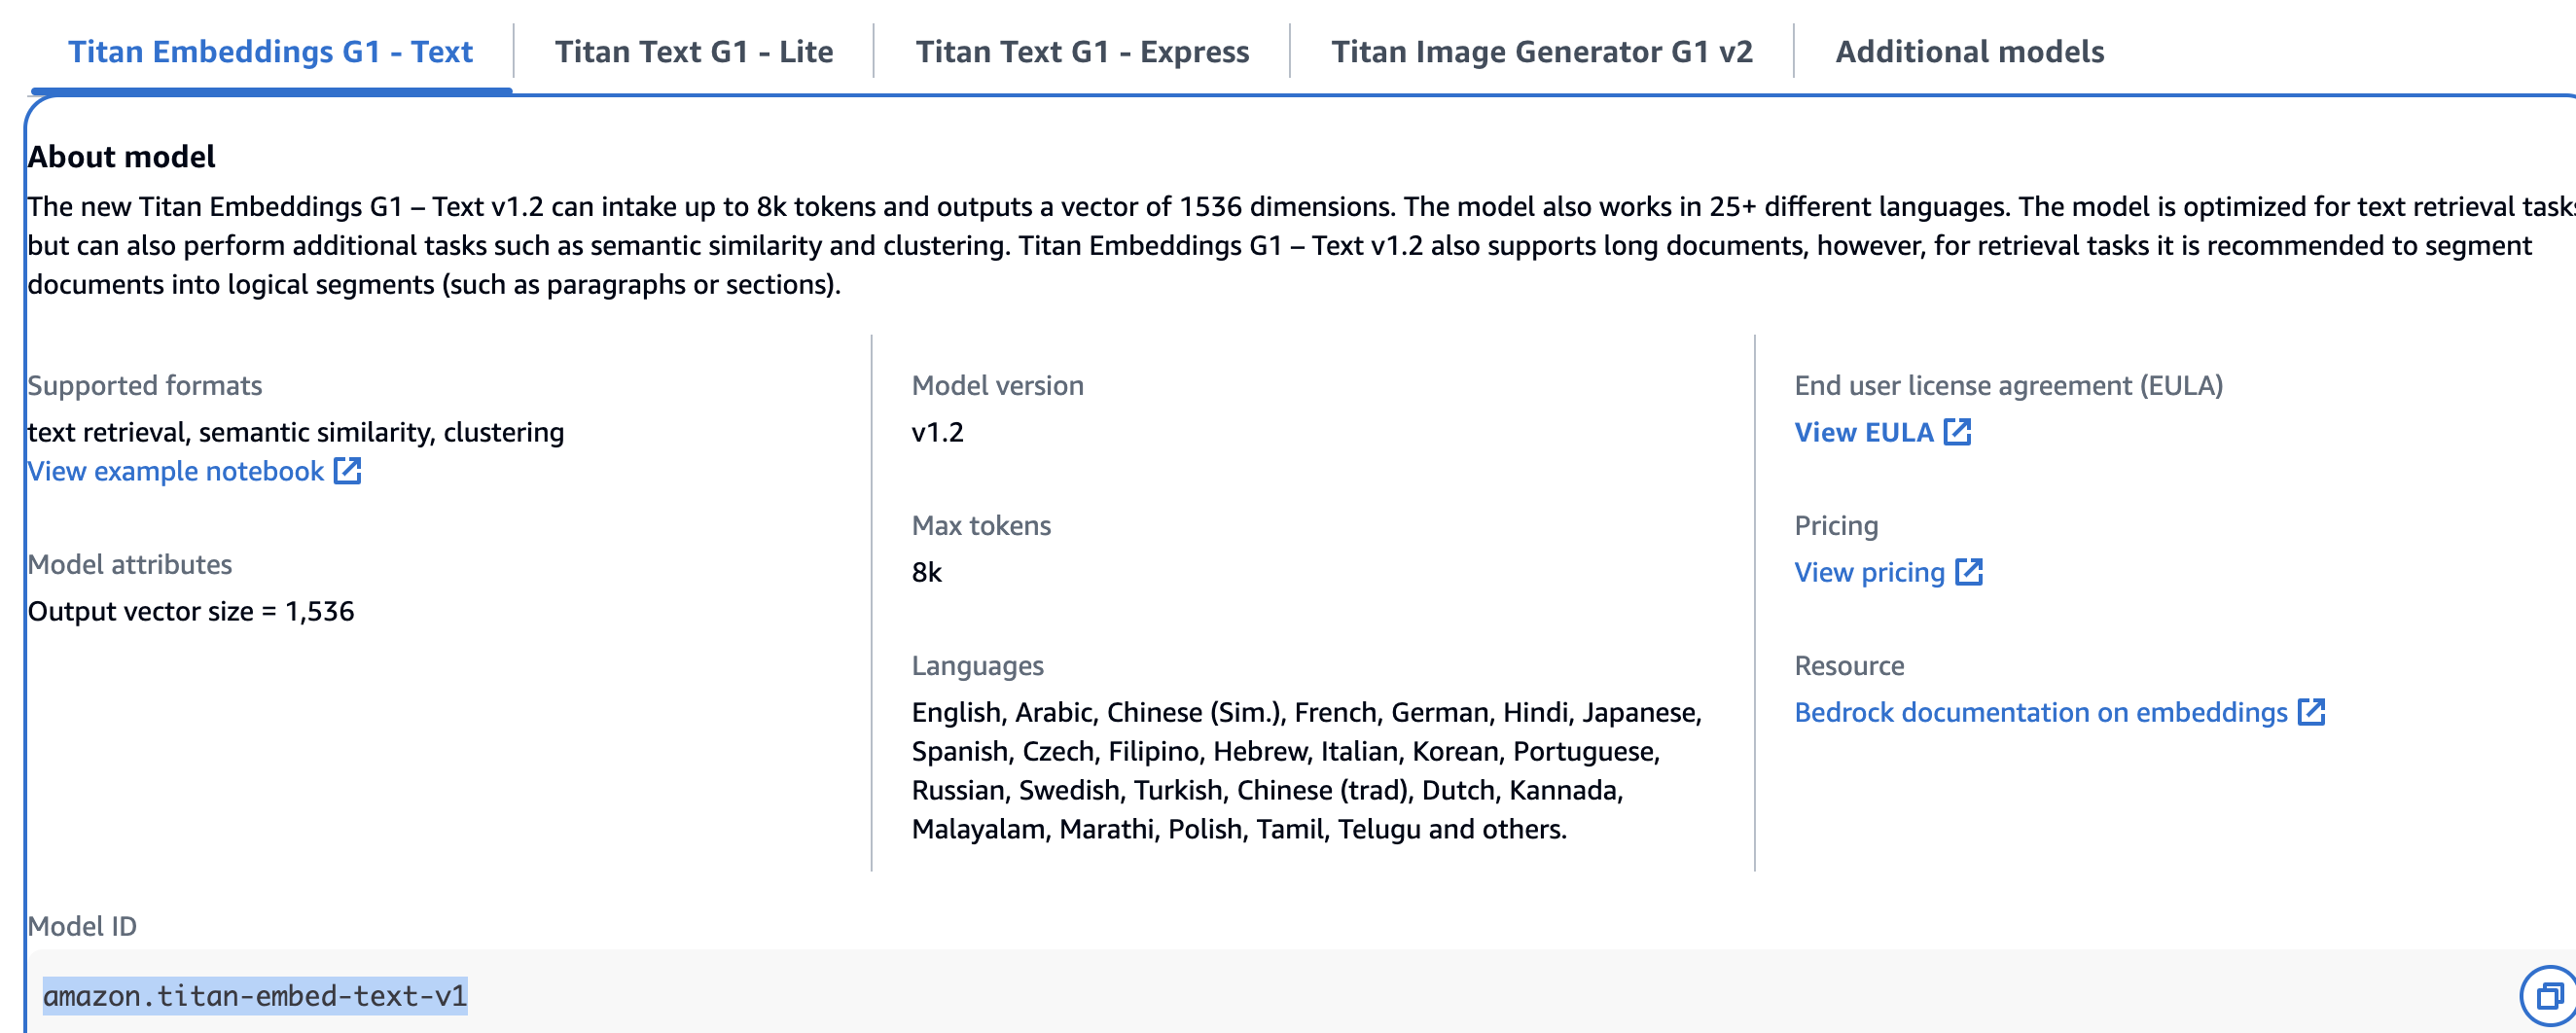

  - `Output vector size = 1,536`, indicates that `AVS` index corresponding to this model should have dimension of 1536, i.e. encoded data and decoded vector would be of size 1536.
  - `amazon.titan-embed-text-v1` is the modelid of this mdoel.

- In the same way, we can also enable other models.

- This demo assumes that users have enabled access to `Titan Text Embeddings V2` and `Titan Embeddings G1 - Text`. The models can be accessed on this [page](https://us-west-2.console.aws.amazon.com/bedrock/home?region=us-west-2#/models)
    - selected moldels are  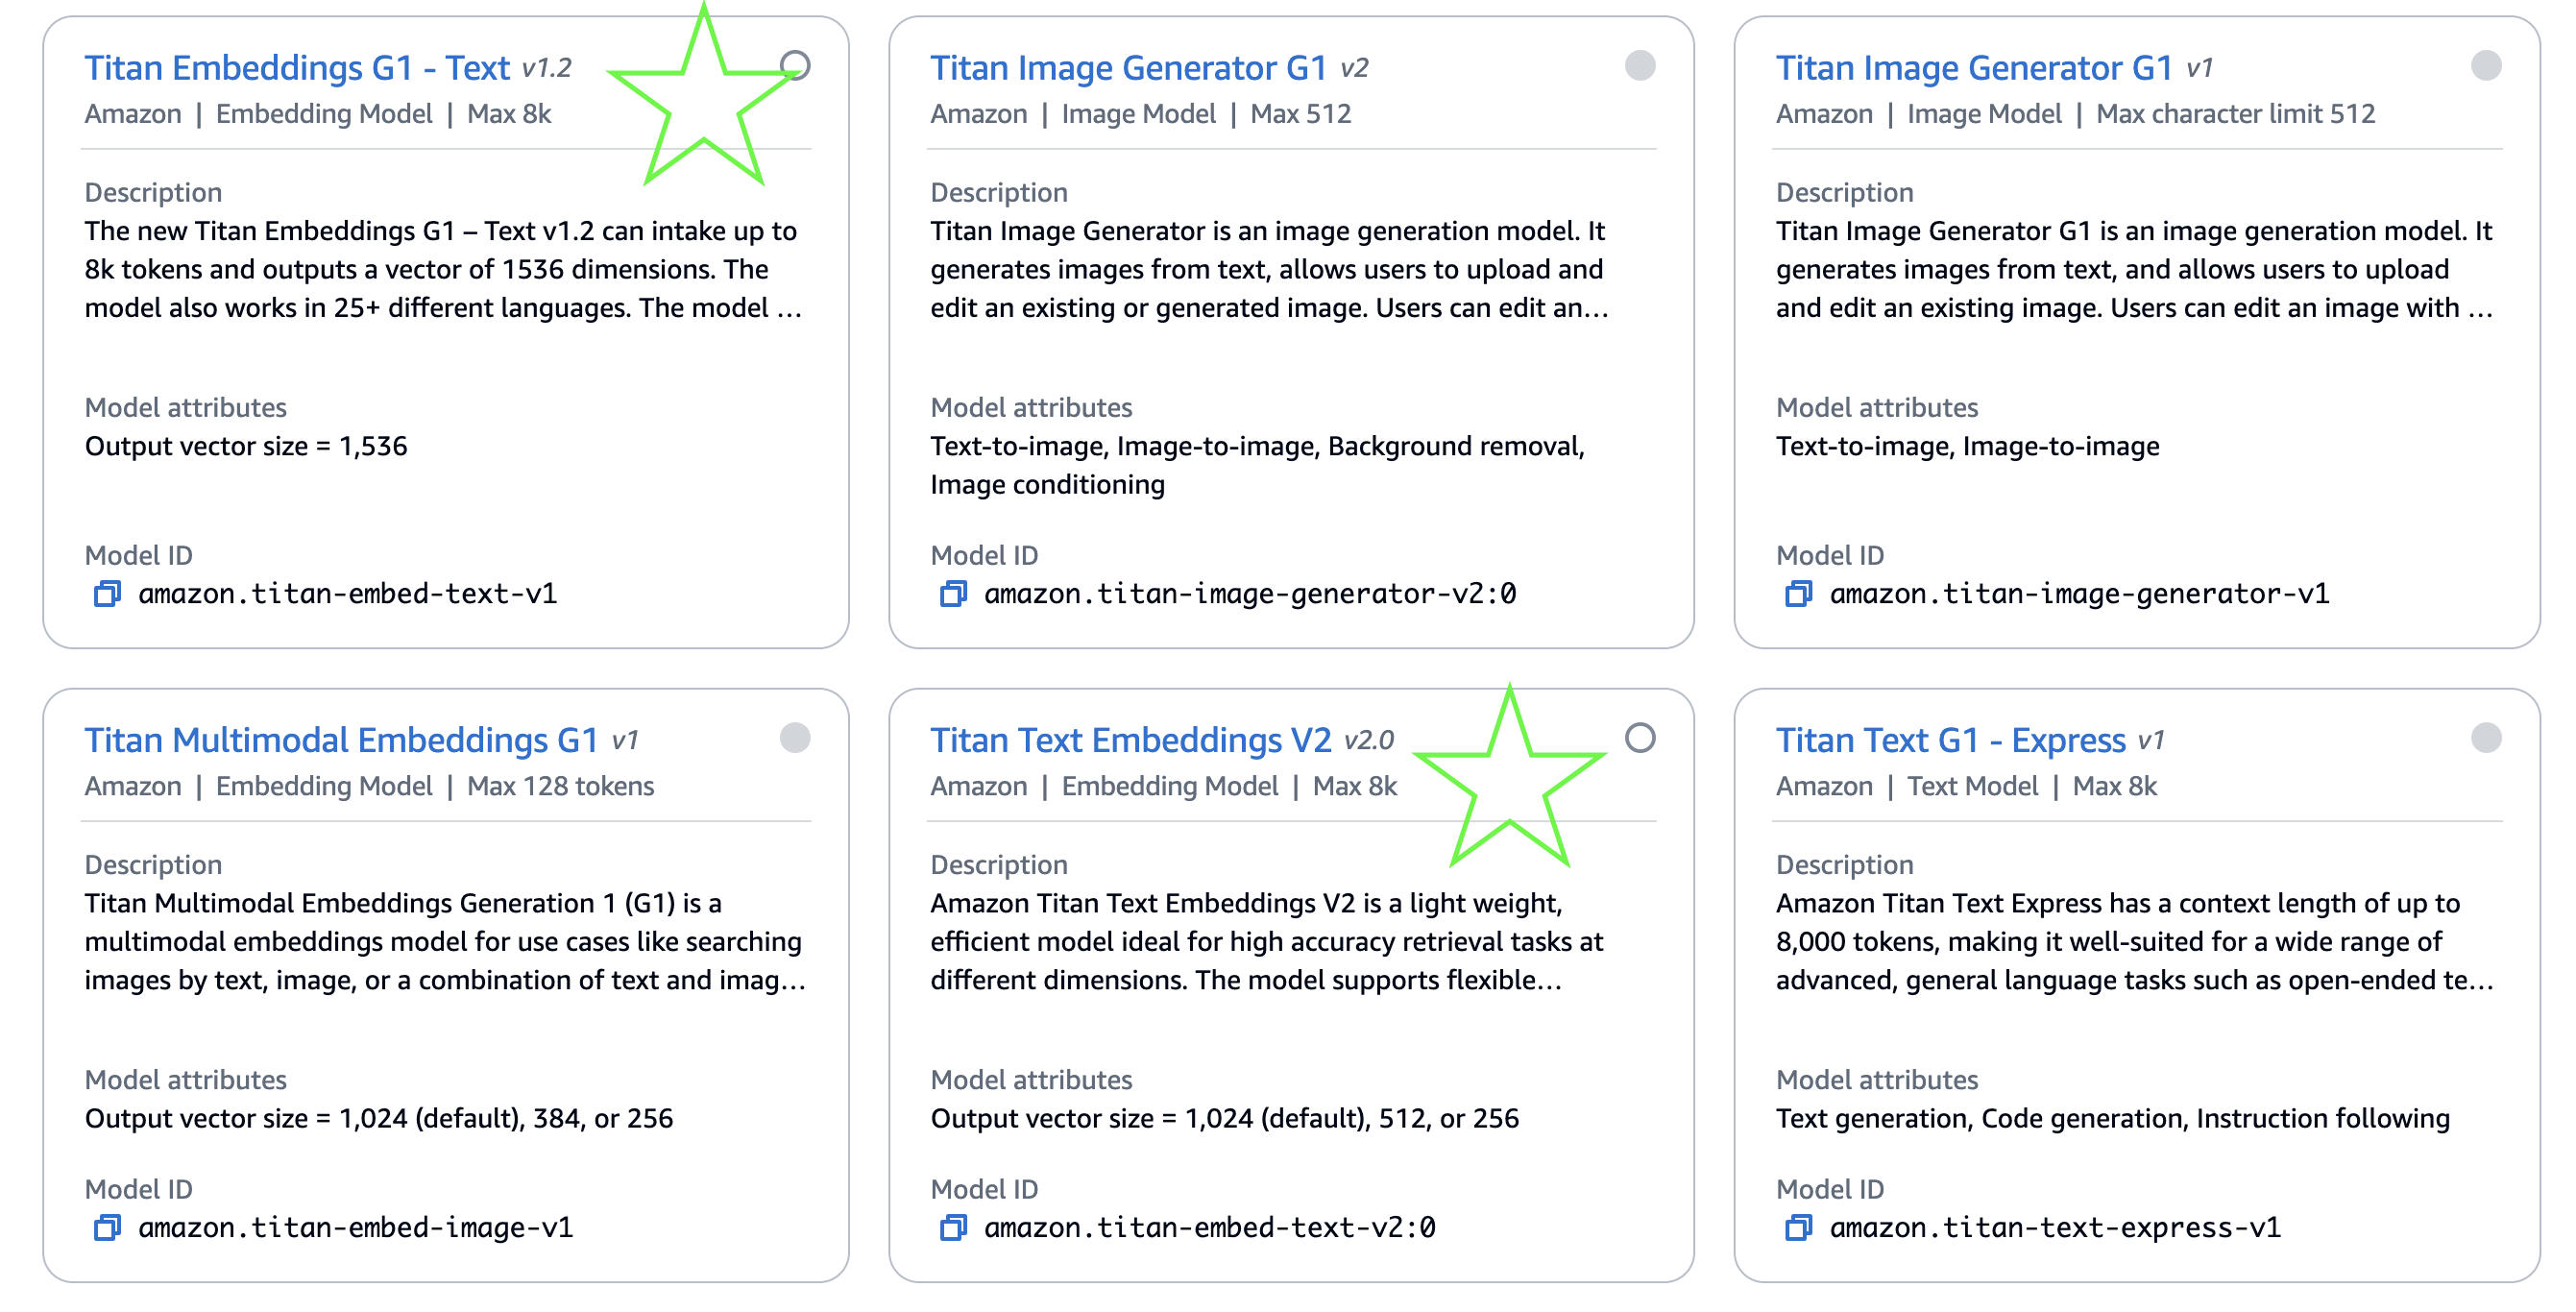

### Utility function to create bedrock_embedding

In [6]:
def make_embedding(model_id):
  '''
   Creates BedrockEmbeddings client depending with given model_id
  '''

  bedrock_embedding = BedrockEmbeddings(
                model_id= model_id,
                client = bedrock_client,
  )
  return bedrock_embedding

### Utility function to create an Index in AVS

In [ ]:
def create_index(admin_client, index_name, index_dimension):
  '''
   Creates an AVS index with provided name and index dimension
  '''

  index_exists = False
  # Check if the index already exists. If not, create it
  for index in admin_client.index_list():
    if (
        index["id"]["namespace"] == AVS_NAMESPACE
        and index["id"]["name"] == index_name
    ):
        index_exists = True
        print(f"{index_name} already exists. Skipping creation")
        break

  # Create the HNSW index in Aerospike Vector Search
  if not index_exists:
    admin_client.index_create(
        namespace=AVS_NAMESPACE,
        name=index_name,
        dimensions=index_dimension,
        vector_distance_metric=MODEL_DISTANCE_CALC,
        vector_field=VECTOR_KEY,
    )

### Initialize [Aerospike vector store client](https://python.langchain.com/v0.2/api_reference/community/vectorstores/langchain_community.vectorstores.aerospike.Aerospike.html#langchain_community.vectorstores.aerospike.Aerospike)
 - This vector store client can both add data to and retrieve relevant data from the AVS vector store.

In [ ]:
def create_vector_store(avs_user_client, index_namespace, bedrock_embedding, index_name):
    """
    Creates and configures an instance of a vector store using AVS as the backend.
    """

    vector_store = Aerospike(
        namespace=index_namespace,
        client=avs_user_client,
        embedding=bedrock_embedding,
        index_name=index_name,
        distance_strategy=MODEL_DISTANCE_CALC,
        vector_key=VECTOR_KEY,
    )

    return vector_store

### Utility function to read topkenize pdf document
 - Please refer to [RecursiveCharacterTextSplitter]([https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/) for more details.

In [ ]:

def split_pdf_documents():
    """
    Loads a PDF document from a specified URL and splits the document into
    passages based on a defined token count of 500 tokens per chunk, with no overlap between chunks.

    This function utilizes a PyPDFLoader to load a PDF from a URL. It then uses a
    RecursiveCharacterTextSplitter to split the loaded text into chunks. Each chunk consists
    of 500 tokens, and chunks do not overlap.
    """

    loader = PyPDFLoader("https://aerospike.com/files/ebooks/aerospike-up-and-running-early-release3.pdf")
    data = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
    documents = text_splitter.split_documents(data)
    return documents

### Utility function to search and print results

In [ ]:
def search_and_print(vector_store):
    """
    Executes a similarity search on a given vector store using the specified query,
    and prints the content of each result on the terminal.
    """
    results = vector_store.similarity_search(query=simple_query)
    for r in results:
        print("== " + r.page_content)

### Demo
 - For each model in `model_dims` map, we create corresponding bedrock embedding and `AVS` index.
 - We use embedding and index to create a vectorstore client
 - vector store client is used to store and retrieve data from AVS for a sample query `simple_query`

In [ ]:
#This map contains the model_id and its corresponding vector size
#When creating an vector store index, we must specify the required dimension
model_dims = { "amazon.titan-embed-text-v2:0" : 1024, "amazon.titan-embed-text-v1" : 1536}

simple_query = "Aerospike database storage solutions"

tokenized_documents = split_pdf_documents()

#Instance of AVS admin client, used to create index
avs_admin_client = AdminClient(
    seeds=types.HostPort(
        host=AVS_HOST,
        port=AVS_PORT,
    ),
    is_loadbalancer=True,
)

#Instantiate the AVS user client, which is used for storing and retrieving vectors from the vector store.
avs_client = Client(
    seeds=types.HostPort(
        host=AVS_HOST,
        port=AVS_PORT,
    ),
    is_loadbalancer=True,
)

index_prefix = "test-"

#For each model configuration in `model_id`, we create an index, store embedded PDF documents in AVS, and retrieve similar documents from AVS for a sample query
for i, model_id in enumerate(model_dims):
    dimension = model_dims[model_id]
    model_info = "model:{} dimension:{}".format(model_id, dimension)
    print(model_info)

    embedding = make_embedding(model_id)
    assert embedding is not None, "embedding should not be None"

    index_name= index_prefix + str(i)

    # create an AVS index for this model
    create_index(avs_admin_client, index_name, dimension)

    #create vector store for this model
    vector_store = create_vector_store(avs_client, AVS_NAMESPACE, embedding, index_name)
    assert vector_store is not None, "vector_store should not be None"

    #add the documents into vector store
    vector_store.add_documents(tokenized_documents)

    print("=====searching and printing for model:" + model_id + "======")

    search_and_print(vector_store, simple_query)


#close the admin and user client instances
avs_admin_client.close()
avs_client.close()
